In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
!pip install contractions
import contractions
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

     |████████████████████████████████| 245kB 4.6MB/s 
     |████████████████████████████████| 317kB 20.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81695 sha256=63fe27df52e60dc2e3ba9a56f4654e2a4004a89b95840ca81ad148db015eae2f
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/DamiFur/DiploDatos-StanceDetection/master/train.csv", sep=',', encoding="latin1").fillna(method="ffill")
test = pd.read_csv("https://raw.githubusercontent.com/DamiFur/DiploDatos-StanceDetection/master/test.csv", sep=',', encoding="latin1").fillna(method="ffill")

In [3]:
abortion_train = train[train["Target"] == "Legalization of Abortion"]
abortion_test = test[test["Target"] == "Legalization of Abortion"]

In [4]:
abortion_train.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)
abortion_test.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)

In [5]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

In [6]:
def preprocesar(text, keep_hashtags=True, remove_numbers=True):
    
    text = contractions.fix(text) 
    
    toks = tokenizer.tokenize(text)
    
    ret = []
    for tok in toks:
        
        if re.match('https?://[A-Za-z0-9./]+',tok):
            continue

        if re.match('[A-Za-z0-9./]+@[A-Za-z0-9./]+',tok):
            continue
            
        if re.match(r'[^\w\s\#,]',tok): #emoji
            continue
            
        if re.match('[^?!.,]*[?.!,]$',tok): #puntuaciones
            continue
        
        if tok.isnumeric() and remove_numbers:
            continue
        ret.append(tok)
    return " ".join(ret)

In [7]:
abortion_train["Tweet"] = abortion_train["Tweet"].apply(lambda x: preprocesar(x))
abortion_test["Tweet"] = abortion_test["Tweet"].apply(lambda x: preprocesar(x))

Balanceo de Clases

In [8]:
train_abortion_against = abortion_train[abortion_train.Stance=="AGAINST"]
train_abortion_favor = abortion_train[abortion_train.Stance=="FAVOR"]
train_abortion_none = abortion_train[abortion_train.Stance=="NONE"]
   
train_abortion_subsampled = resample(train_abortion_against, 
                                      replace=True,  
                                      n_samples=len(train_abortion_favor),   
                                      random_state=123)

train_abortion_subsampled_none = resample(train_abortion_none, 
                                      replace=True,  
                                      n_samples=len(train_abortion_favor),   
                                      random_state=123)

abortion_train_balanced = pd.concat([train_abortion_subsampled, train_abortion_favor, train_abortion_subsampled_none])
abortion_train_balanced['Stance'].value_counts()

NONE       121
AGAINST    121
FAVOR      121
Name: Stance, dtype: int64

In [9]:
abortion_train_balanced["Tweet"] = abortion_train_balanced["Tweet"].apply(lambda x: preprocesar(x))

In [10]:
train_abortion, validation_abortion = train_test_split(
    abortion_train_balanced, 
    test_size=0.2, 
    random_state=42
)

In [11]:
y_test = abortion_test["Stance"]
y_train = train_abortion["Stance"]
y_validation = validation_abortion["Stance"]

In [12]:
def dataset_vectorizer(input_train, input_validation, input_test):
    text_train = input_train["Tweet"]
    text_validation = input_validation["Tweet"]
    text_test = input_test["Tweet"]

    vectorizer = CountVectorizer(
        binary=True, min_df=0.004, max_df=0.7, ngram_range=(1, 3)
    )

    X_result = vectorizer.fit_transform([*text_train, *text_validation, *text_test])

    VEC_train = X_result[:len(text_train)]
    VEC_validation = X_result[len(text_train):-len(text_test)]
    VEC_test = X_result[-len(text_test):]
    
    return VEC_train, VEC_validation, VEC_test

In [13]:
VEC_train_abortion, VEC_validation_abortion, VEC_test_abortion = dataset_vectorizer(train_abortion, validation_abortion, abortion_test)

In [14]:
VEC_validation_abortion.sort_indices()
VEC_train_abortion.sort_indices()
VEC_test_abortion.sort_indices()

In [15]:
# El output de nuestra red neuronal tiene que ser un valor numérico
codes = {}
codes["NONE"] = 0
codes["FAVOR"] = 1
codes["AGAINST"] = 2

def toNumeric(stance):
    return codes[stance]

labels = np.array(y_train.apply(lambda x: toNumeric(x)))
validation = np.array(y_validation.apply(lambda x: toNumeric(x)))
test = np.array(y_test.apply(lambda x: toNumeric(x)))

# labels = list(map(toNumeric, train_abortion["Stance"]))
# validation = list(map(toNumeric, validation_abortion["Stance"]))

In [16]:
input_dim = VEC_train_abortion.shape[1]

alpha = 0.1
nodes_per_hidden_layer = 20
hidden_layer_depth = 1
activation = "softmax"# softmax, relu, tanh,
learning_rate = 1e-02

model = Sequential()
model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim))

# Esto lo pueden usar si quieren agregar varias capas
#for i in range(hidden_layer_depth):
#     model.add(Dense(nodes_per_hidden_layer))

model.add(Activation(activation))

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=learning_rate), 
              metrics=['accuracy'])

# model.summary()
history = model.fit(x=VEC_train_abortion, y=labels, batch_size=1, epochs=1000, verbose=1, validation_data=(VEC_validation_abortion, validation))

Epoch 1/1000
290/290 [==============================] - 1s 2ms/step - loss: 2.2990 - accuracy: 0.4069 - val_loss: 1.8601 - val_accuracy: 0.3425
Epoch 2/1000
290/290 [==============================] - 0s 969us/step - loss: 1.4297 - accuracy: 0.7000 - val_loss: 1.4539 - val_accuracy: 0.5342
Epoch 3/1000
290/290 [==============================] - 0s 972us/step - loss: 1.0873 - accuracy: 0.7966 - val_loss: 1.2740 - val_accuracy: 0.5205
Epoch 4/1000
290/290 [==============================] - 0s 957us/step - loss: 0.9054 - accuracy: 0.8276 - val_loss: 1.1752 - val_accuracy: 0.5479
Epoch 5/1000
290/290 [==============================] - 0s 942us/step - loss: 0.7887 - accuracy: 0.8690 - val_loss: 1.1138 - val_accuracy: 0.5890
Epoch 6/1000
290/290 [==============================] - 0s 954us/step - loss: 0.7040 - accuracy: 0.8862 - val_loss: 1.0742 - val_accuracy: 0.5753
Epoch 7/1000
290/290 [==============================] - 0s 925us/step - loss: 0.6392 - accuracy: 0.9034 - val_loss: 1.0384 - v

In [ ]:
# model.save('softmax_1000_classification_model.h5')

# from keras.models import load_model
# pretrained_model = load_model('MNIST_classification_model.h5')

In [17]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

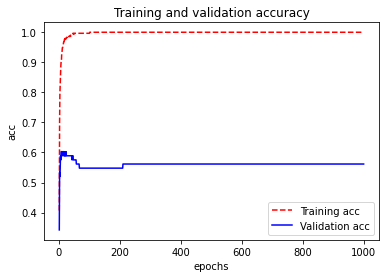

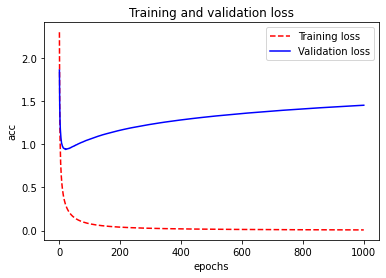

<Figure size 432x288 with 0 Axes>

In [18]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Training loss' )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [20]:
print('numero de epoch para menor valor de loss (validation)')

print(val_loss.index(min(val_loss)))

print('numero de epoch para mayor valor de accuracy (validation)')

print(val_acc.index(max(val_acc)))

numero de epoch para menor valor de loss (validation)
20
numero de epoch para mayor valor de accuracy (validation)
6


In [21]:
y_pred_test =  model.predict_classes(VEC_test_abortion)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [22]:
accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.51
F1 micro para conjunto de test: 0.51
F1 macro para conjunto de test: 0.48
F1 average para conjunto de test: 0.55
Exactitud del algoritmo para conjunto de test: 0.51


### Entrenamos con 30 epochs

In [23]:
input_dim = VEC_train_abortion.shape[1]

alpha = 0.1
nodes_per_hidden_layer = 20
hidden_layer_depth = 1
activation = "softmax"# softmax, relu, tanh,
learning_rate = 1e-02

model = Sequential()
model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim))

# Esto lo pueden usar si quieren agregar varias capas
#for i in range(hidden_layer_depth):
#     model.add(Dense(nodes_per_hidden_layer))

model.add(Activation(activation))

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=learning_rate), 
              metrics=['accuracy'])

history = model.fit(x=VEC_train_abortion, y=labels, batch_size=1, epochs=30, verbose=1, validation_data=(VEC_validation_abortion, validation))

Epoch 1/30
290/290 [==============================] - 0s 1ms/step - loss: 2.2703 - accuracy: 0.4034 - val_loss: 1.8454 - val_accuracy: 0.4384
Epoch 2/30
290/290 [==============================] - 0s 967us/step - loss: 1.4223 - accuracy: 0.6621 - val_loss: 1.4570 - val_accuracy: 0.4932
Epoch 3/30
290/290 [==============================] - 0s 962us/step - loss: 1.0834 - accuracy: 0.7897 - val_loss: 1.2912 - val_accuracy: 0.5068
Epoch 4/30
290/290 [==============================] - 0s 1ms/step - loss: 0.9040 - accuracy: 0.8310 - val_loss: 1.1825 - val_accuracy: 0.5616
Epoch 5/30
290/290 [==============================] - 0s 1ms/step - loss: 0.7862 - accuracy: 0.8828 - val_loss: 1.1221 - val_accuracy: 0.5753
Epoch 6/30
290/290 [==============================] - 0s 1ms/step - loss: 0.7019 - accuracy: 0.8828 - val_loss: 1.0788 - val_accuracy: 0.5890
Epoch 7/30
290/290 [==============================] - 0s 1ms/step - loss: 0.6376 - accuracy: 0.9138 - val_loss: 1.0448 - val_accuracy: 0.6164
Ep

In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

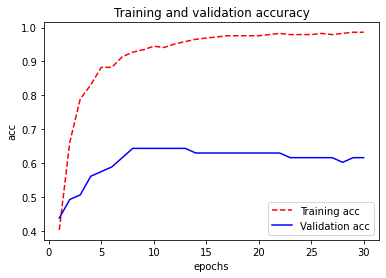

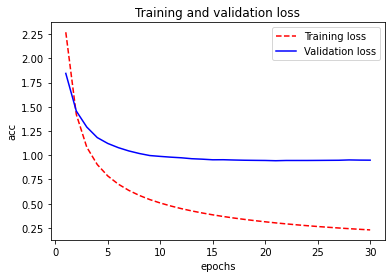

<Figure size 432x288 with 0 Axes>

In [25]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Training loss' )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [26]:
y_pred_test =  model.predict_classes(VEC_test_abortion)

In [27]:
accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.51
F1 micro para conjunto de test: 0.51
F1 macro para conjunto de test: 0.49
F1 average para conjunto de test: 0.56
Exactitud del algoritmo para conjunto de test: 0.51


**Se realizó un primer entrenamiento con 1000 epoch y batch size = 1, observamos que aproximadamente luego del epoch 50 comienza a descender el accuracy y a aumentar el valor de loss, obteniendo las siguientes metricas.**

Accuracy para conjunto de test: 0.51
F1 micro para conjunto de test: 0.51
F1 macro para conjunto de test: 0.48
F1 average para conjunto de test: 0.55
Exactitud del algoritmo para conjunto de test: 0.51 

**Por lo cual decidimos realizar un segundo entrenamiento pero solo con 50 epochs, obteniendo las siguientes metricas.**

Accuracy para conjunto de test: 0.50
F1 micro para conjunto de test: 0.50
F1 macro para conjunto de test: 0.47
F1 average para conjunto de test: 0.53
Exactitud del algoritmo para conjunto de test: 0.50  



In [ ]:
def create_model(activation='relu'):
    input_dim = VEC_train_abortion.shape[1]
    alpha = 0.1
    nodes_per_hidden_layer = 20
    hidden_layer_depth = 1
    # activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    learning_rate = 1e-02

    model = Sequential()
    model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim))
    model.add(Activation(activation))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=learning_rate), 
              metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from time import time
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

start=time()
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=1)
optimizers = ['SGD']
# init = ['glorot_uniform', 'normal', 'uniform']
epochs = np.array([50])
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid_result = grid.fit(VEC_train_abortion, labels) #(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
232/232 [==============================] - 0s 913us/step - loss: 2.4058 - accuracy: 0.4009
Epoch 2/50
232/232 [==============================] - 0s 859us/step - loss: 1.5544 - accuracy: 0.6595
Epoch 3/50
232/232 [==============================] - 0s 862us/step - loss: 1.1775 - accuracy: 0.8060
Epoch 4/50
232/232 [==============================] - 0s 839us/step - loss: 0.9740 - accuracy: 0.8578
Epoch 5/50
232/232 [==============================] - 0s 806us/step - loss: 0.8416 - accuracy: 0.9095
Epoch 6/50
232/232 [==============================] - 0s 822us/step - loss: 0.7463 - accuracy: 0.9181
Epoch 7/50
232/232 [==============================] - 0s 760us/step - loss: 0.6738 - accuracy: 0.9267
Epoch 8/50
232/232 [==============================] - 0s 842us/step - loss: 0.6151 - accuracy: 0.9353
Epoch 9/50
232/232 [==============================] - 0s 792us/step - loss: 0.5679 - accuracy: 0.9397
Epoch 10/50
232/232 [==============================] - 0s 778us/step - loss: 0.527

In [ ]:
y_pred_test = grid_result.predict(VEC_test_abortion)

In [ ]:
accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.53
F1 micro para conjunto de test: 0.53
F1 macro para conjunto de test: 0.49
F1 average para conjunto de test: 0.56
Exactitud del algoritmo para conjunto de test: 0.53


## VOTING

In [ ]:
def create_model(activation='softmax'):
    input_dim = VEC_train_abortion.shape[1]
    alpha = 0.1
    nodes_per_hidden_layer = 20
    hidden_layer_depth = 1
    # activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    learning_rate = 1e-02

    model = Sequential()
    model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim))
    model.add(Activation(activation))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=learning_rate), 
              metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from time import time
import numpy

In [ ]:
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(random_state=2, n_estimators=100, criterion='entropy')
clf2 = SVC(C = 1.0, kernel = "rbf", gamma=0.5, tol = 1e-3)
clf3 = KerasClassifier(build_fn=create_model, epochs=50, batch_size=1, verbose=0)
clf3._estimator_type = "classifier"  

eclf1 = VotingClassifier(estimators=[('rf', clf1), ('svc', clf2), ('keras', clf3)], voting='hard')
eclf1 = eclf1.fit(VEC_train_abortion, labels)
print(eclf1.predict(VEC_test_abortion))

[2 0 1 0 2 1 1 2 0 1 0 1 0 1 1 0 2 1 1 2 2 1 2 1 1 1 1 2 1 0 0 0 0 1 2 2 0
 0 0 0 1 1 1 2 0 0 0 0 0 1 0 2 1 1 1 0 1 1 1 1 0 1 1 0 2 2 0 0 0 0 1 1 1 0
 1 0 1 0 1 0 0 0 0 1 0 2 2 0 0 0 2 2 0 2 1 1 2 0 0 1 2 1 0 0 0 1 0 0 0 0 1
 2 0 2 1 0 0 0 2 0 1 0 1 1 0 1 2 0 1 0 1 1 1 0 2 1 1 0 0 1 1 0 2 0 1 1 0 1
 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 2 0 2 2 1 1 0 1
 1 2 0 0 0 0 1 1 0 2 1 0 1 1 2 0 0 0 0 2 2 0 0 0 0 1 2 0 0 2 1 0 2 0 2 0 2
 0 0 1 0 1 1 0 1 0 0 0 2 1 0 0 1 0 1 0 1 1 2 1 0 0 2 1 0 1 0 1 0 1 2 0 0 1
 1 0 0 0 0 1 1 2 0 1 0 1 0 2 1 2 0 0 1 2 2]


In [ ]:
y_pred_test = eclf1.predict(VEC_test_abortion)

accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.39
F1 micro para conjunto de test: 0.39
F1 macro para conjunto de test: 0.40
F1 average para conjunto de test: 0.40
Exactitud del algoritmo para conjunto de test: 0.39
